In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

In [35]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

class DualInputCEBRA(nn.Module):
    """Model handling two types of data with a CEBRA-style encoder and VAE decoder."""
    def __init__(self, num_neurons, num_indexes, num_units, latent_dim):
        super().__init__()
        # Neural data encoder
        self.neural_encoder = nn.Sequential(
            nn.Conv1d(1, num_units, 2),  # Assuming single channel input
            nn.GELU(),
            _Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU()),
            _Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU()),
            _Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU()),
            nn.Conv1d(num_units, latent_dim, 3),
            nn.Flatten()
        )
        
        # Index data encoder
        self.index_encoder = nn.Sequential(
            nn.Conv1d(1, num_units, 2),  # Assuming single channel input
            nn.GELU(),
            _Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU()),
            _Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU()),
            _Skip(nn.Conv1d(num_units, num_units, 3), nn.GELU()),
            nn.Conv1d(num_units, latent_dim, 3),
            nn.Flatten()
        )
        
        # Decoder (generates neural data from latent space)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, num_units),
            nn.GELU(),
            nn.Linear(num_units, num_neurons),
            nn.Sigmoid()  # Normalize the output
        )

    def forward(self, neural_data, index_data):
        neural_data = neural_data.unsqueeze(1)  # Add channel dimension
        index_data = index_data.unsqueeze(1)  # Add channel dimension
        z_neural = self.neural_encoder(neural_data)
        z_index = self.index_encoder(index_data)
        reconstructed = self.decoder(z_neural)
        return reconstructed, z_neural, z_index

    def compute_loss(self, reconstructed, neural_data, z_neural, z_index):
        BCE = F.binary_cross_entropy(reconstructed, neural_data, reduction='sum')
        MSE = F.mse_loss(z_neural, z_index)  # Contrastive loss
        return BCE + MSE


# Assuming neural data and index data are loaded correctly
neural_data = cebra.datasets.init('rat-hippocampus-single-achilles').neural
index_data = cebra.datasets.init('rat-hippocampus-single-achilles').continuous_index.numpy()

# Initialize dataset and dataloader
dataset = NeuralDataset(neural_data, index_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
model = ContrastiveMaskedVAE(neural_input_dim=120, index_input_dim=3, hidden_dim=100, latent_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



/tmp/ipykernel_49091/3921718612.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.neural_data = torch.tensor(neural_data, dtype=torch.float32)


In [36]:

# Assume 'model' and 'dataloader' are already defined
embeddings_list = []  # This will store the embeddings

num_epochs = 50
for epoch in range(num_epochs):
    epoch_embeddings = []
    for neural_batch, index_batch in dataloader:
        optimizer.zero_grad()
        mask = (torch.rand_like(neural_batch) < 0.9).float()
        reconstructed, mu_neural, log_var_neural, z_neural, z_index = model(neural_batch, index_batch, mask)
        loss = model.compute_loss(reconstructed, neural_batch, mu_neural, log_var_neural, z_neural, z_index)
        loss.backward()
        optimizer.step()

        # Collect embeddings for visualization
        epoch_embeddings.append(z_neural.detach().cpu().numpy())  # Detach and move to CPU for visualization

    embeddings_list.append(np.concatenate(epoch_embeddings, axis=0))
    print(f'Epoch {epoch + 1}: Loss = {loss.item()}')

# Optionally, average or simply use the embeddings from the last epoch for visualization
final_embeddings = np.concatenate(embeddings_list, axis=0)

Epoch 1: Loss = 31.796913146972656
Epoch 2: Loss = 49.87836837768555
Epoch 3: Loss = 53.408714294433594
Epoch 4: Loss = 42.358428955078125
Epoch 5: Loss = 41.51994323730469
Epoch 6: Loss = 41.27104949951172
Epoch 7: Loss = 35.57007598876953
Epoch 8: Loss = 22.992794036865234
Epoch 9: Loss = 34.93199157714844
Epoch 10: Loss = -158.81365966796875
Epoch 11: Loss = 39.4185676574707
Epoch 12: Loss = 24.071041107177734
Epoch 13: Loss = 45.97086715698242
Epoch 14: Loss = 29.234046936035156
Epoch 15: Loss = 26.019611358642578
Epoch 16: Loss = 31.290239334106445
Epoch 17: Loss = -81.64939880371094
Epoch 18: Loss = 34.197906494140625
Epoch 19: Loss = 35.83338928222656
Epoch 20: Loss = 20.888214111328125
Epoch 21: Loss = -37.45994186401367
Epoch 22: Loss = 31.30251121520996
Epoch 23: Loss = 40.48028564453125
Epoch 24: Loss = 23.83797836303711
Epoch 25: Loss = 40.213348388671875
Epoch 26: Loss = 30.40721893310547
Epoch 27: Loss = 30.450489044189453
Epoch 28: Loss = 37.115638732910156
Epoch 29: Los

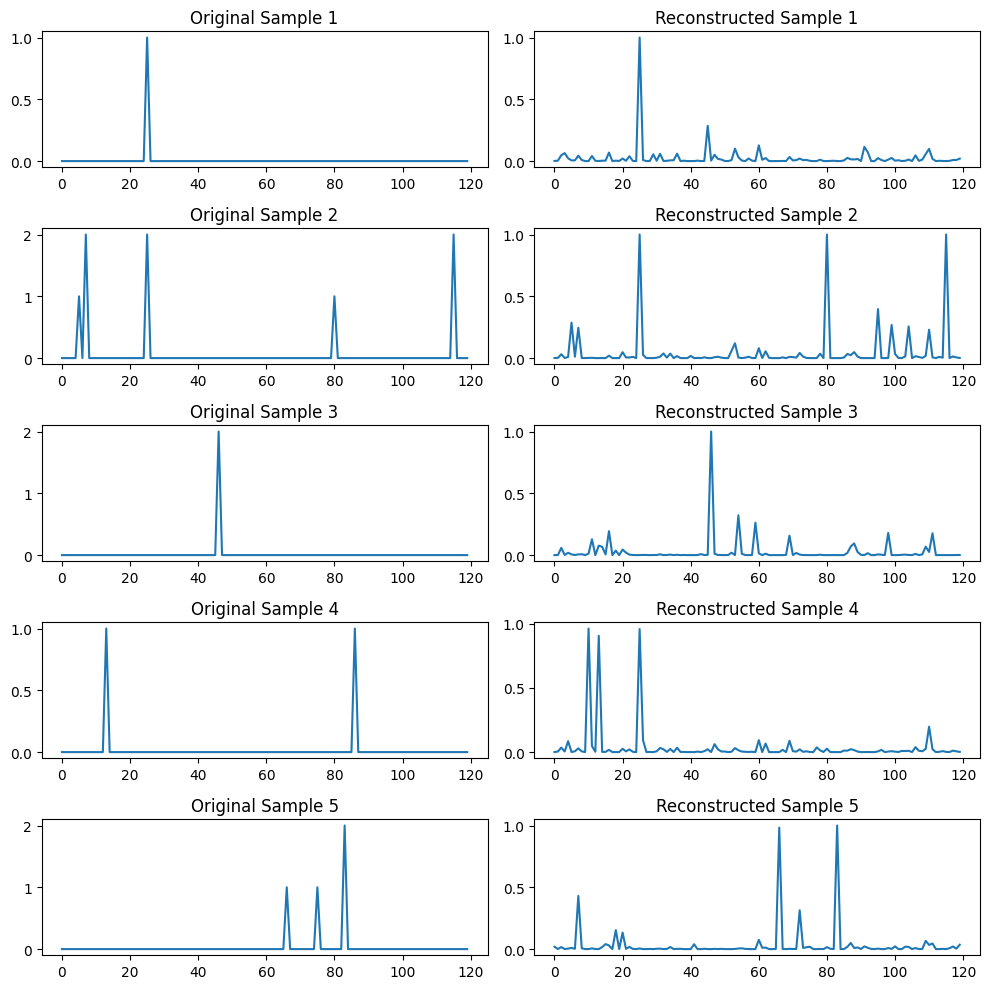

In [37]:
# Evaluate the model by plotting original and reconstructed data
model.eval()
with torch.no_grad():
    # Take a single batch from the dataloader
    neural_batch, index_batch = next(iter(dataloader))
    mask = torch.ones_like(neural_batch)  # No masking during testing
    reconstructed, _, _, _, _ = model(neural_batch, index_batch, mask)

    # Plotting the first few samples
    num_samples_to_display = 5
    fig, axes = plt.subplots(num_samples_to_display, 2, figsize=(10, 10))
    for i in range(num_samples_to_display):
        axes[i, 0].plot(neural_batch[i].numpy())
        axes[i, 0].set_title(f'Original Sample {i+1}')
        axes[i, 1].plot(reconstructed[i].numpy())
        axes[i, 1].set_title(f'Reconstructed Sample {i+1}')
    plt.tight_layout()
    plt.show()

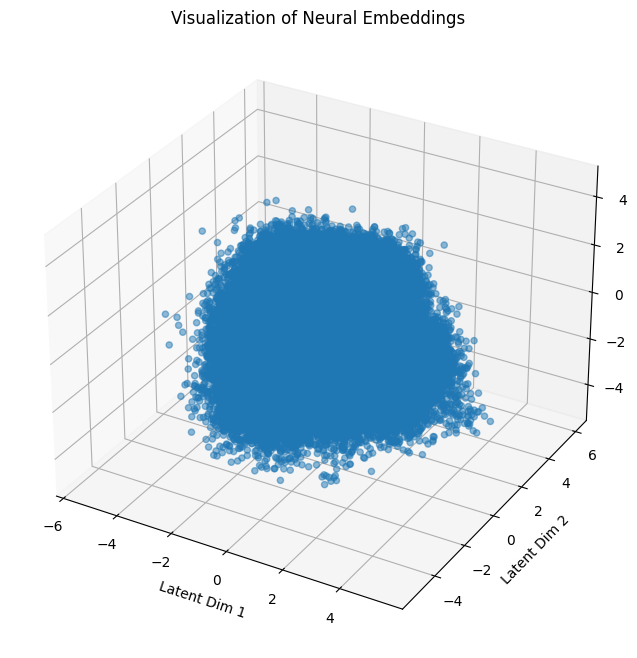

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use final_embeddings or choose another aggregation method as needed
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming final_embeddings is an array with shape (n_samples, 3)
ax.scatter(final_embeddings[:, 0], final_embeddings[:, 1], final_embeddings[:, 2], alpha=0.5)

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_zlabel('Latent Dim 3')
ax.set_title('Visualization of Neural Embeddings')

plt.show()